In [1]:
import argparse
import logging
import sys
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torch.nn.functional as F

from torch.utils.tensorboard import SummaryWriter

from utils import data
import models, utils

import pandas as pd
from laspy.file import File
from pickle import dump, load

import torch.nn as nn
import torch.optim as optim
import torch.utils.data as udata
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [2]:
class Args(object):
    def __init__(self):
        self.data_path= 'data' # not used
        self.dataset= 'masked_pwc' # move lidar into datasets
        self.batch_size= 32
        self.model= 'lidar_unet1d'
        self.in_channels = 7
        self.lr= 0.005
        self.weight_decay = 0.005
        self.num_epochs= 200
        self.n_data = 1 # not used
        self.min_sep = 5 # not used
        self.num_scan_lines = 300
        self.seq_len = 256
        self.val_split = 0.2
        self.scan_line_gap_break = 7000 # threshold over which scan_gap indicates a new scan line
        self.min_pt_count = 1700 # in a scan line, otherwise line not used
        self.max_pt_count = 2000 # in a scan line, otherwise line not used
        self.mask_pts_per_seq = 5
        self.mask_consecutive = True
        # points in between scan lines
        self.stride_inline = 5
        self.stride_across_lines = 3
        self.valid_interval= 1 
        self.save_interval= 1
        self.seed = 0
        self.output_dir= 'lidar_experiments'
        self.experiment= None
        self.resume_training= False
        self.restore_file= None
        self.no_save= False
        self.step_checkpoints= False
        self.no_log= False
        self.log_interval= 100
        self.no_visual= False
        self.visual_interval= 100
        self.no_progress= False
        self.draft= False
        self.dry_run= False
        self.bias= False 
#         self.in_channels= 1 # maybe 6?
        self.test_num = 0
        # UNET
        self.residual = False
        self.wtd_loss = True
args=Args()

In [3]:
# gpu or cpu
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
args = utils.setup_experiment(args)
utils.init_logging(args)

[2020-11-11 12:58:40] COMMAND: /home/michael/python-virtual-environments/data/lib/python3.6/site-packages/ipykernel_launcher.py -f /home/michael/.local/share/jupyter/runtime/kernel-98de3387-639a-4f48-b528-47c6cad72763.json
[2020-11-11 12:58:40] Arguments: {'data_path': 'data', 'dataset': 'masked_pwc', 'batch_size': 32, 'model': 'lidar_unet1d', 'in_channels': 7, 'lr': 0.005, 'weight_decay': 0.005, 'num_epochs': 200, 'n_data': 1, 'min_sep': 5, 'num_scan_lines': 300, 'seq_len': 256, 'val_split': 0.2, 'scan_line_gap_break': 7000, 'min_pt_count': 1700, 'max_pt_count': 2000, 'mask_pts_per_seq': 5, 'mask_consecutive': True, 'stride_inline': 5, 'stride_across_lines': 3, 'valid_interval': 1, 'save_interval': 1, 'seed': 0, 'output_dir': 'lidar_experiments', 'experiment': 'lidar-unet1d-Nov-11-12:58:40', 'resume_training': False, 'restore_file': None, 'no_save': False, 'step_checkpoints': False, 'no_log': False, 'log_interval': 100, 'no_visual': False, 'visual_interval': 100, 'no_progress': False,

In [ ]:
torch.load(MODEL_PATH_LOAD)['model']

In [13]:
# Saving model
# MODEL_PATH = "models/lidar/conv1d_256seq_400epochs_092620.pth"
# torch.save(model.state_dict(), MODEL_PATH)

# Loading models
MODEL_PATH_LOAD = "lidar_experiments/lstm_unet1d/lstm-unet1d-Oct-15-09:00:00/checkpoints/checkpoint_last.pt"

train_new_model = False

# Build data loaders, a model and an optimizer
if train_new_model:
    model = models.build_model(args).to(device)
else:
    model = models.build_model(args)
    model.load_state_dict(torch.load(MODEL_PATH_LOAD)['model'][0])
    model.to(device)

print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay = args.weight_decay)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[25,50,100,250,500], gamma=0.5)
logging.info(f"Built a model consisting of {sum(p.numel() for p in model.parameters()):,} parameters")

if args.resume_training:
    state_dict = utils.load_checkpoint(args, model, optimizer, scheduler)
    global_step = state_dict['last_step']
    start_epoch = int(state_dict['last_step']/(403200/state_dict['args'].batch_size))+1
else:
    global_step = -1
    start_epoch = 0

[2020-10-15 09:56:34] Built a model consisting of 73,280 parameters


UNet(
  (conv1): PartialConv1d(7, 32, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
  (conv2): PartialConv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
  (conv3): PartialConv1d(32, 64, kernel_size=(3,), stride=(2,), padding=(1,), bias=False)
  (conv4): PartialConv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
  (conv5): PartialConv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,), bias=False)
  (conv6): PartialConv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,), bias=False)
  (conv7): PartialConvTranspose1d(64, 64, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
  (conv8): PartialConv1d(96, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
  (conv9): PartialConv1d(32, 3, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
  (dropout): Dropout(p=0.1, inplace=False)
)


In [5]:
# # Load x_train and x_val
x_train,x_val,sc = torch.load('../lidar_data/1d/data_256seq_5_consec_180819_intensity.pt')
# torch.save([x_train,x_val,sc],'data_256seq_5_consec_180819_intensity.pt')

In [6]:
x_train.shape

torch.Size([24080, 7, 256])

In [8]:
x_val.shape

torch.Size([6020, 7, 256])

In [7]:
def add_mask(tensor,mask_pts_per_seq,consecutive=True):
    # Given a 3-D tensor of all ones, returns a mask_tensor of same shape 
    # with random masking determined by mask_pts_per_seq
    mask_tensor = torch.ones(tensor.shape)
    seq_len = mask_tensor.shape[2]
#     mask_idx = np.random.choice(np.arange(10,seq_len-10),mask_pts_per_seq,replace=False)
    for i in range(mask_tensor.shape[0]):
        if consecutive:
            first_mask = np.random.choice(np.arange(10,seq_len-10-mask_pts_per_seq),1)
            m = np.arange(first_mask,first_mask+mask_pts_per_seq)
        else:
            m = np.random.choice(np.arange(10,seq_len-10),mask_pts_per_seq,replace=False)
        mask_tensor[i,:,m] = 0
    return mask_tensor


# Create mask tensor
mask_train = add_mask(x_train,args.mask_pts_per_seq,args.mask_consecutive)
mask_val = add_mask(x_val,args.mask_pts_per_seq,args.mask_consecutive)

In [8]:
# Dataloader class
class LidarLstmDataset(udata.Dataset):
    def __init__(self, x, mask):
        super(LidarLstmDataset, self).__init__()
        self.x = x
        self.mask = mask

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self,index):
        return self.x[index],self.mask[index]

In [8]:
# Define a loss function that weights the loss according to coordinate ranges (xmax-xmin, ymax-ymin, zmax-zmin)
def weighted_MSELoss(pred,true,sc,mask_pts_per_seq=args.mask_pts_per_seq):
    '''weighted_MSELoss reconverts MSE loss back to the original scale of x,y,z.
    Rationale is because xyz have such different ranges, we don't want to ignore the ones with largest scale.
    Assumes that x,y,z are the first 3 features in sc scaler'''
    
    ranges = torch.Tensor(sc.data_max_[:3]-sc.data_min_[:3])
    raw_loss = torch.zeros(3,dtype=float)
    for i in range(3):
        raw_loss[i] = F.mse_loss(pred[:,i,:], true[:,i,:], reduction="sum") 
    return (ranges**2 * raw_loss).sum()

def calculate_loss(model,sc,x,y_true,ltype='Training'):
    # Training loss
    y_pred = model(x).detach().to('cpu')
    loss = weighted_MSELoss(y_pred.unsqueeze(1), y_true,sc)
    print("{} Loss: {:.4f}".format(ltype,loss))
    return loss

In [9]:
# Create the dataloaders
train_dataset = LidarLstmDataset(x_train,mask_train)
val_dataset = LidarLstmDataset(x_val,mask_val)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, num_workers=4, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, num_workers=4, shuffle=False)

In [11]:
a = next(iter(train_loader))
a[0].shape

torch.Size([32, 7, 256])

In [ ]:
# Track moving average of loss values
train_meters = {name: utils.RunningAverageMeter(0.98) for name in (["train_loss"])}
valid_meters = {name: utils.AverageMeter() for name in (["valid_loss"])}
writer = SummaryWriter(log_dir=args.experiment_dir) if not args.no_visual else None

In [ ]:
# TRAINING
for epoch in range(start_epoch, args.num_epochs):
    if args.resume_training:
        if epoch %10 == 0:
            optimizer.param_groups[0]["lr"] /= 2
            print('learning rate reduced by factor of 2')

    train_bar = utils.ProgressBar(train_loader, epoch)
    for meter in train_meters.values():
        meter.reset()

    for batch_id, (clean, mask) in enumerate(train_bar):
        # dataloader returns [clean, mask] list
        model.train()
        global_step += 1
        inputs = clean.to(device)
        mask_inputs = mask.to(device)
        # only use the mask part of the outputs
        raw_outputs = model(inputs,mask_inputs)
        outputs = (1-mask_inputs[:,:3,:])*raw_outputs + mask_inputs[:,:3,:]*inputs[:,:3,:]
        
        if args.wtd_loss:
            loss = weighted_MSELoss(outputs,inputs[:,:3,:],sc)/(inputs.size(0)*args.mask_pts_per_seq)
            # Regularization?
            
        else:
            # normalized by the number of masked points
            loss = F.mse_loss(outputs, inputs[:,:3,:], reduction="sum") / (inputs.size(0) * args.mask_pts_per_seq)

        model.zero_grad()
        loss.backward()
        optimizer.step()

        train_meters["train_loss"].update(loss)
        train_bar.log(dict(**train_meters, lr=optimizer.param_groups[0]["lr"]), verbose=True)

        if writer is not None and global_step % args.log_interval == 0:
            writer.add_scalar("lr", optimizer.param_groups[0]["lr"], global_step)
            writer.add_scalar("loss/train", loss.item(), global_step)
            gradients = torch.cat([p.grad.view(-1) for p in model.parameters() if p.grad is not None], dim=0)
            writer.add_histogram("gradients", gradients, global_step)
            sys.stdout.flush()

    if epoch % args.valid_interval == 0:
        model.eval()
        for meter in valid_meters.values():
            meter.reset()

        valid_bar = utils.ProgressBar(valid_loader)
        val_loss = 0
        for sample_id, (clean, mask) in enumerate(valid_bar):
            with torch.no_grad():
                inputs = clean.to(device)
                mask_inputs = mask.to(device)
                # only use the mask part of the outputs
                raw_output = model(inputs,mask_inputs)
                output = (1-mask_inputs[:,:3,:])*raw_output + mask_inputs[:,:3,:]*inputs[:,:3,:]

                # TO DO, only run loss on masked part of output
                
                if args.wtd_loss:
                    val_loss = weighted_MSELoss(output,inputs[:,:3,:],sc)/(inputs.size(0)*args.mask_pts_per_seq)
                else:
                    # normalized by the number of masked points
                    val_loss = F.mse_loss(output, inputs[:,:3,:], reduction="sum")/(inputs.size(0)* \
                                                                                    args.mask_pts_per_seq)

                valid_meters["valid_loss"].update(val_loss.item())

        if writer is not None:
            writer.add_scalar("loss/valid", valid_meters['valid_loss'].avg, global_step)
            sys.stdout.flush()

        logging.info(train_bar.print(dict(**train_meters, **valid_meters, lr=optimizer.param_groups[0]["lr"])))
        utils.save_checkpoint(args, global_step, model, optimizer, score=valid_meters["valid_loss"].avg, mode="min")
    scheduler.step()

logging.info(f"Done training! Best Loss {utils.save_checkpoint.best_score:.3f} obtained after step {utils.save_checkpoint.best_step}.")


## 

In [14]:
def plot_mask(data,mask=None,x=0,y=1,xlabel='X',ylabel='Y',seq_len=256,mask_pts_per_seq=args.mask_pts_per_seq):
    fontsize=12
    if mask == None:
        plt.plot(data[0,x,:],data[0,y,:],'x')
    else:
        # Receivers
        infilled = np.zeros([mask.shape[0],3,mask_pts_per_seq]) 
        true = np.zeros([mask.shape[0],3,mask_pts_per_seq]) 
        original = np.zeros([mask.shape[0],3,seq_len-mask_pts_per_seq])

        # j counts infilled, k counts other
        j = 0
        k = 0
        for i in range(data.shape[2]):
            if mask[0,0,i] == 0:
                infilled[:,:,j] = data[:,:,i]
                true[:,:,j] = clean[:,:3,i]
                j+=1
            else:
                original[:,:,k] = data[:,:,i]
                k+=1
        plt.plot(original[0,x,:],original[0,y,:],'x',color='lightgrey',label='Other')
        plt.plot(infilled[0,x,:],infilled[0,y,:],'or',label='Predicted')
        plt.plot(true[0,x,:],true[0,y,:],'og',label='True')
    plt.xlabel(xlabel,fontsize=fontsize,fontweight='bold')
    plt.ylabel(ylabel,fontsize=fontsize,fontweight='bold')
    plt.legend(fontsize=fontsize)

def plot_sub(clean,output,mask,seq_len,mask_pts_per_seq):
    fontsize=12
    plt.figure(figsize=[12,15])

    plt.subplot(3,2,1)
    plot_mask(clean,x=0,y=1,xlabel='X',ylabel='Y',seq_len=seq_len,mask_pts_per_seq=mask_pts_per_seq)
    plt.title("True Data",fontsize=fontsize)

    plt.subplot(3,2,2)
    plot_mask(output,mask[:,:3,:],x=0,y=1,xlabel='X',ylabel='Y',seq_len=seq_len,mask_pts_per_seq=mask_pts_per_seq)
    plt.title("Inpainted data",fontsize=fontsize)

    plt.subplot(3,2,3)
    plot_mask(output,x=1,y=2,xlabel='Y',ylabel='Z',seq_len=seq_len,mask_pts_per_seq=mask_pts_per_seq)

    plt.subplot(3,2,4)
    plot_mask(output,mask[:,:3,:],x=1,y=2,xlabel='Y',ylabel='Z',seq_len=seq_len,mask_pts_per_seq=mask_pts_per_seq)

    plt.subplot(3,2,5)
    plot_mask(output,x=0,y=2,xlabel='X',ylabel='Z',seq_len=seq_len,mask_pts_per_seq=mask_pts_per_seq)
    plt.subplot(3,2,6)
    plot_mask(output,mask[:,:3,:],x=0,y=2,xlabel='X',ylabel='Z',seq_len=seq_len,mask_pts_per_seq=mask_pts_per_seq)

def plot_sub_short(clean,output,mask,seq_len,mask_pts_per_seq):
    fontsize=12
    plt.figure(figsize=[18,8])

    plt.subplot(1,3,1)
    plot_mask(output,mask[:,:3,:],x=0,y=1,xlabel='X',ylabel='Y',seq_len=seq_len,mask_pts_per_seq=mask_pts_per_seq)

    plt.subplot(1,3,2)
    plot_mask(output,mask[:,:3,:],x=1,y=2,xlabel='Y',ylabel='Z',seq_len=seq_len,mask_pts_per_seq=mask_pts_per_seq)

    plt.subplot(1,3,3)
    plot_mask(output,mask[:,:3,:],x=0,y=2,xlabel='X',ylabel='Z',seq_len=seq_len,mask_pts_per_seq=mask_pts_per_seq)

    
    
def plot_sub_interp(clean,output,mask,seq_len,mask_pts_per_seq,mask_consecutive=True):
    fontsize=12
    plt.figure(figsize=[15,15])
    
    output_interp = interp(clean,mask,mask_pts_per_seq,mask_consecutive)
    
    plt.subplot(2,2,1)
    plot_mask(output,mask[:,:3,:],x=1,y=2,xlabel='Y',ylabel='Z',seq_len=seq_len,mask_pts_per_seq=mask_pts_per_seq)
    plt.title("Conv1D Model",fontsize=fontsize,fontweight='bold')
    
    plt.subplot(2,2,2)
    plot_mask(output_interp,mask[:,:3,:],x=1,y=2,xlabel='Y',ylabel='Z',seq_len=seq_len,mask_pts_per_seq=mask_pts_per_seq)
    plt.title("Interpolation",fontsize=fontsize,fontweight='bold')
    
    plt.subplot(2,2,3)
    plot_mask(output,mask[:,:3,:],x=0,y=2,xlabel='X',ylabel='Z',seq_len=seq_len,mask_pts_per_seq=mask_pts_per_seq)

    plt.subplot(2,2,4)
    plot_mask(output_interp,mask[:,:3,:],x=0,y=2,xlabel='X',ylabel='Z',seq_len=seq_len,mask_pts_per_seq=mask_pts_per_seq)

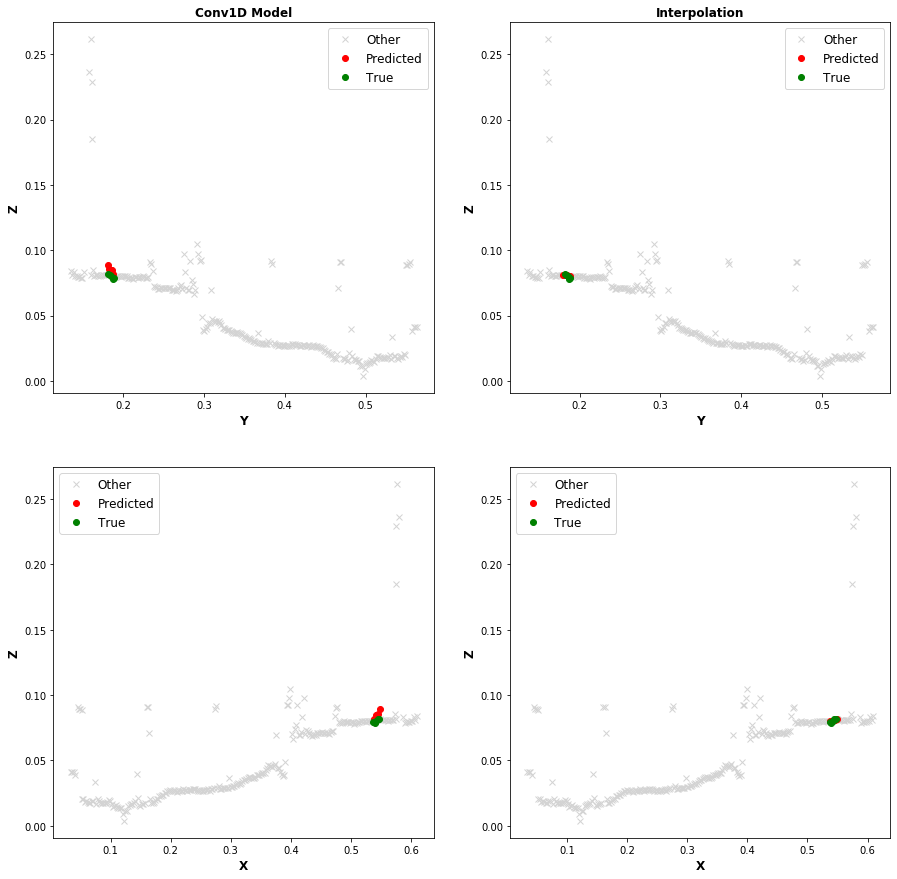

In [15]:
clean, mask = next(iter(train_loader))
inputs = clean.to(device)
mask_inputs = mask.to(device)
# only use the mask part of the outputs
raw_output = model(inputs,mask_inputs)
output_gpu = (1-mask_inputs[:,:3,:])*raw_output + mask_inputs[:,:3,:]*inputs[:,:3,:]
output = output_gpu.to('cpu').detach()

plot_sub_interp(clean,output,mask,256,args.mask_pts_per_seq)

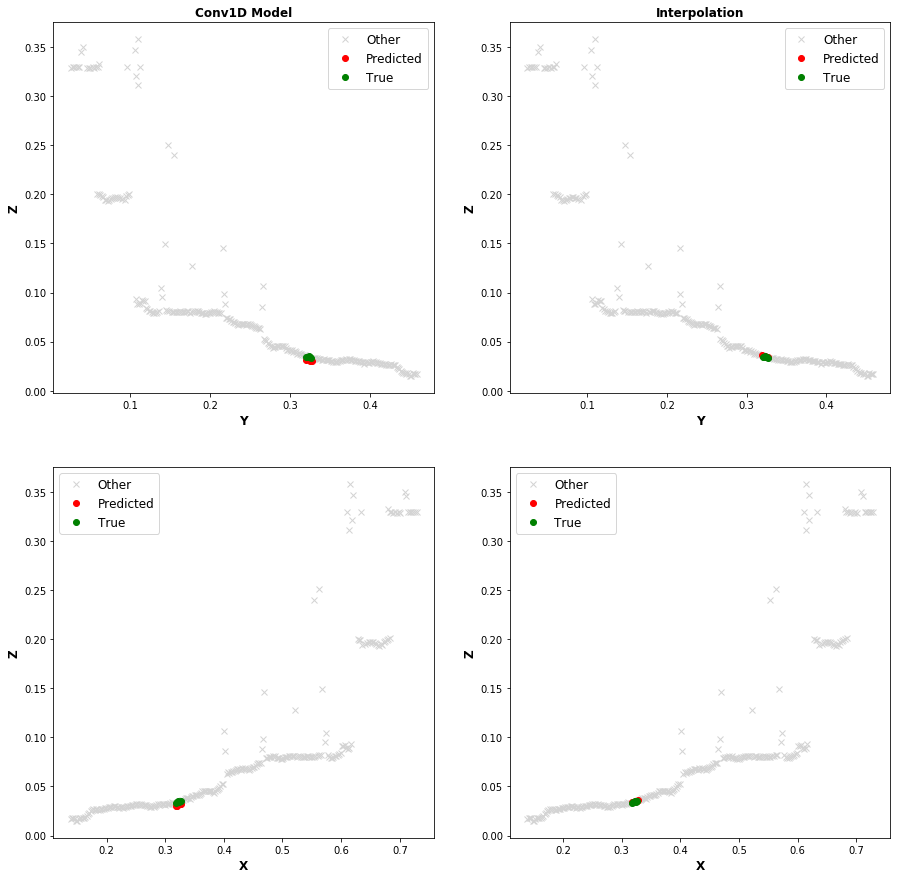

In [16]:
clean, mask = next(iter(train_loader))
inputs = clean.to(device)
mask_inputs = mask.to(device)
# only use the mask part of the outputs
raw_output = model(inputs,mask_inputs)
output_gpu = (1-mask_inputs[:,:3,:])*raw_output + mask_inputs[:,:3,:]*inputs[:,:3,:]
output = output_gpu.to('cpu').detach()

plot_sub_interp(clean,output,mask,256,args.mask_pts_per_seq)

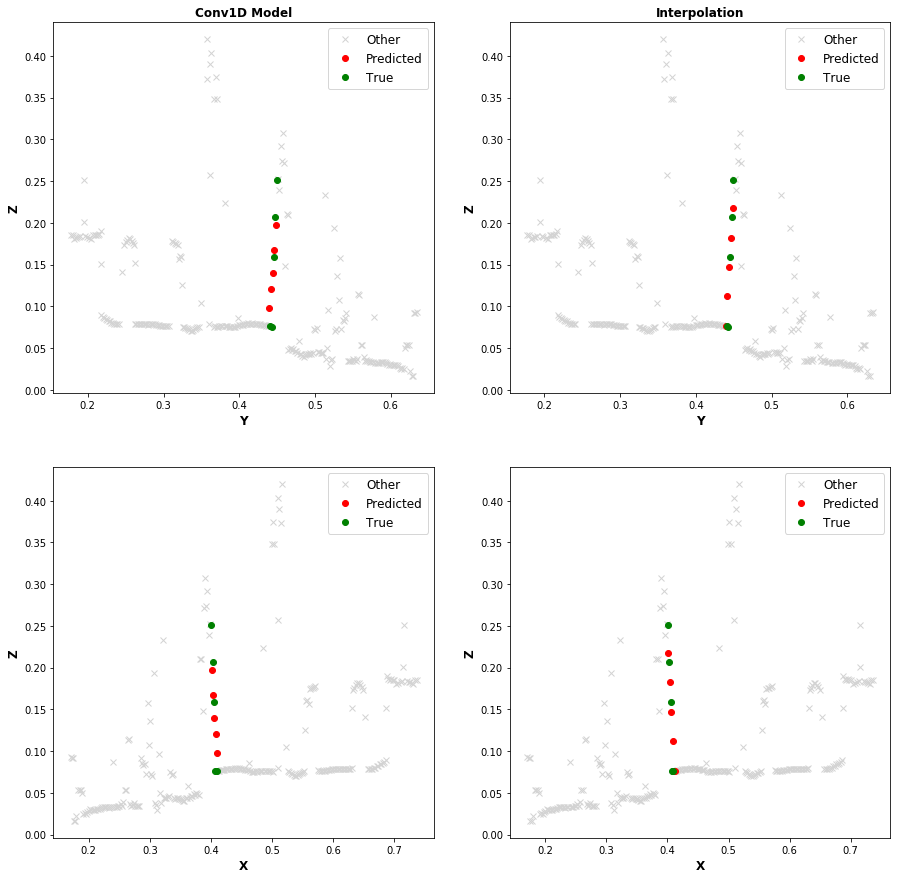

In [17]:
clean, mask = next(iter(train_loader))
inputs = clean.to(device)
mask_inputs = mask.to(device)
# only use the mask part of the outputs
raw_output = model(inputs,mask_inputs)
output_gpu = (1-mask_inputs[:,:3,:])*raw_output + mask_inputs[:,:3,:]*inputs[:,:3,:]
output = output_gpu.to('cpu').detach()

plot_sub_interp(clean,output,mask,256,args.mask_pts_per_seq)

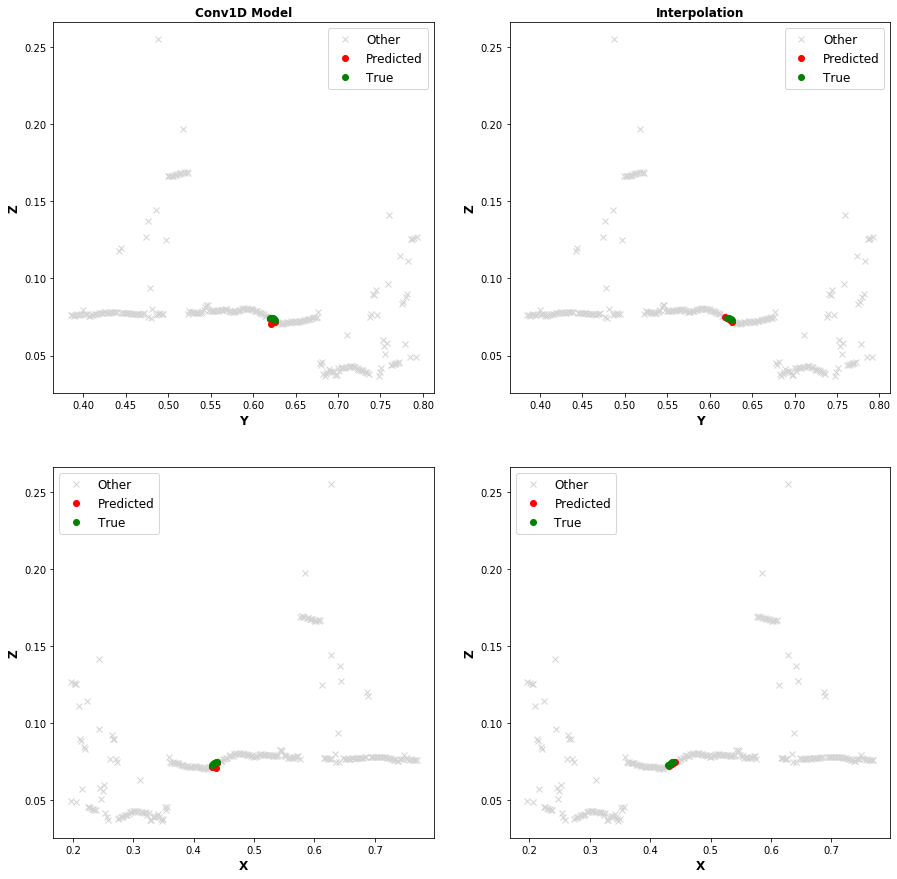

In [18]:
clean, mask = next(iter(train_loader))
inputs = clean.to(device)
mask_inputs = mask.to(device)
# only use the mask part of the outputs
raw_output = model(inputs,mask_inputs)
output_gpu = (1-mask_inputs[:,:3,:])*raw_output + mask_inputs[:,:3,:]*inputs[:,:3,:]
output = output_gpu.to('cpu').detach()

plot_sub_interp(clean,output,mask,256,args.mask_pts_per_seq)

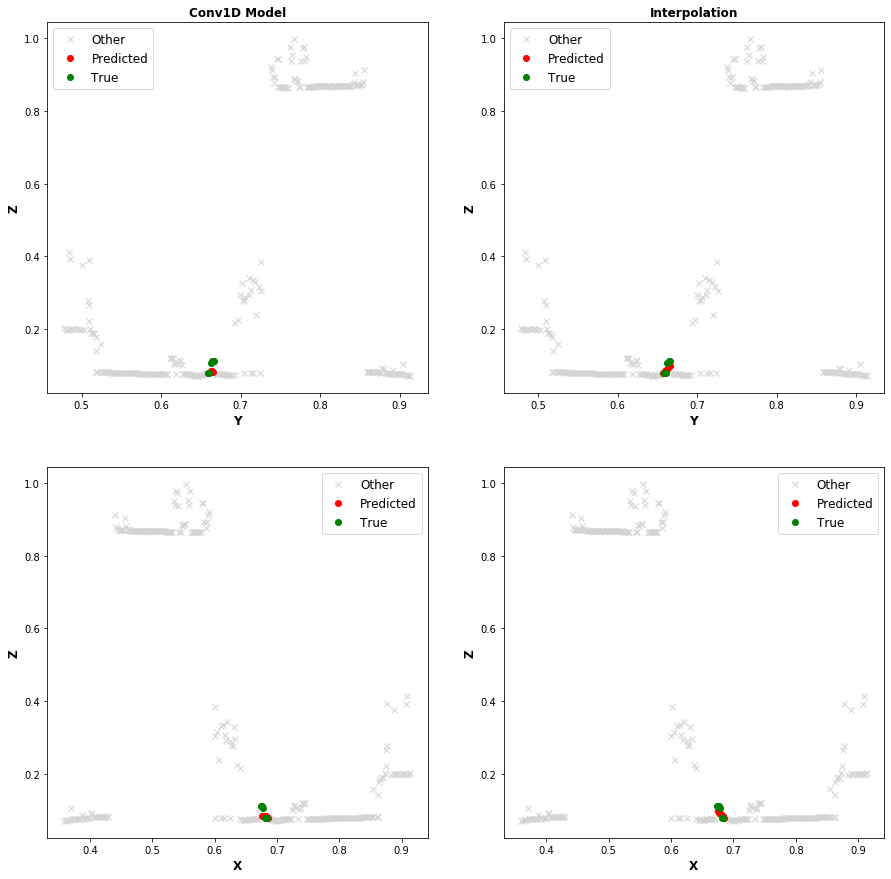

In [19]:
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, num_workers=4, shuffle=True)
clean, mask = next(iter(valid_loader))
inputs = clean.to(device)
mask_inputs = mask.to(device)
# only use the mask part of the outputs
raw_output = model(inputs,mask_inputs)
output_gpu = (1-mask_inputs[:,:3,:])*raw_output + mask_inputs[:,:3,:]*inputs[:,:3,:]
output = output_gpu.to('cpu').detach()

plot_sub_interp(clean,output,mask,256,args.mask_pts_per_seq)

## Baselines
First: Interpolate between last and next

In [10]:
def interp(i,m,mask_pts_per_seq,mask_consecutive=True):
    # Interpolation
    output_interp = (i*m)[:,:3,:]
    for j,sample in enumerate(i):

        if mask_consecutive:
            idx = np.arange(m.shape[2])[m[j,0,:]==0]
            slope = (sample[:3,idx.max()+1]-sample[:3,idx.min()-1]) / mask_pts_per_seq
            interp = (sample[:3,idx.min()-1].unsqueeze(1)+slope.unsqueeze(1)*np.arange(mask_pts_per_seq)).to(dtype=torch.float32)
        else:
            idx = np.arange(inputs.shape[2])[m[j,0,:]==0]
            interp = float(sample[:3,idx-1]+ sample[:3,idx+1])/2
        output_interp[j,:,idx] = interp
    return output_interp

In [20]:
import gc
gc.collect()
# model_cpu = model.to('cpu')
def loss_comparison(loader,model,mask_pts_per_seq=args.mask_pts_per_seq,pt_count=len(val_dataset)):
    wtd_loss = True
    loss_model = 0
    loss_interp = 0
    for batch_id, (i, m) in enumerate(loader):
        with torch.no_grad():
            # conv1D model
            inputs = i.to(device)
            mask = m.to(device)
            raw_output = model(inputs,mask)
            output_model = (1-mask[:,:3,:])*raw_output + mask[:,:3,:]*inputs[:,:3,:]
            
            # Interpolation
            output_interp = interp(i,m,args.mask_pts_per_seq,args.mask_consecutive)

            if wtd_loss:
                loss_model+=weighted_MSELoss(output_model,inputs[:,:3,:],sc)
                loss_interp+=weighted_MSELoss(output_interp,i[:,:3,:],sc)
            else:
                # normalized by the number of masked points
                loss_model += F.mse_loss(output_model, inputs[:,:3,:], reduction="sum") 
                                        
                loss_interp += F.mse_loss(output_interp, i[:,:3,:], reduction="sum") 

    # Normalize by number of batches
    loss_model = loss_model/(mask_pts_per_seq*pt_count)
    loss_interp = loss_interp/(mask_pts_per_seq*pt_count)
    print("Validation Loss\n","*"*30)
    print("Model: {:2.2f}".format(loss_model))
    print("Interpolation: {:2.2f}".format(loss_interp))
    gc.collect()

# loss_comparison(train_loader,model)
loss_comparison(train_loader,model,pt_count=len(train_dataset))

Validation Loss
 ******************************
Model: 14.87
Interpolation: 20.71


In [21]:
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, num_workers=1, shuffle=False)
loss_comparison(valid_loader,model)

Validation Loss
 ******************************
Model: 3230.51
Interpolation: 96.59


## Load the data

In [ ]:
# Training Data parameters
scan_line_gap_break = args.scan_line_gap_break # threshold over which scan_gap indicates a new scan line
min_pt_count = args.min_pt_count # in a scan line, otherwise line not used
max_pt_count = args.max_pt_count # in a scan line, otherwise line not used
num_scan_lines = args.num_scan_lines # to use as training set
val_split = args.val_split
seq_len = args.seq_len
# points in between scan lines
stride_inline = args.stride_inline
stride_across_lines = args.stride_across_lines

# Note: x_scaled, y_scaled, and z_scaled MUST be the first 3 features
feature_list = [
    'x_scaled',
    'y_scaled',
    'z_scaled',
    'scan_line_idx',
    'scan_angle_deg',
    'abs_scan_angle_deg',
    'intensity',
    'miss_pts_before'
]

In [ ]:
first_return_df = pd.read_pickle("../../lidar/Data/parking_lot/first_returns_modified_180231.pkl")
first_return_df.head(10)

In [ ]:
# miss_pts_before is the count of missing points before the point in question (scan gap / 5 -1)
first_return_df['miss_pts_before'] = round((first_return_df['scan_gap']/-5)-1)
first_return_df['miss_pts_before'] = [max(0,pt) for pt in first_return_df['miss_pts_before']]

# Add 'mask' column, set to one by default
first_return_df['mask'] = [1]*first_return_df.shape[0]

In [ ]:
# Add abs_scan_angle_deg as a feature
first_return_df['abs_scan_angle_deg'] = abs(first_return_df['scan_angle_deg'])

#### Extract tensor of scan lines

In [ ]:
# Number of points per scan line
scan_line_pt_count = first_return_df.groupby('scan_line_idx').count()['gps_time']

# Identify the indices for points at end of scan lines
scan_break_idx = first_return_df[(first_return_df['scan_gap']>scan_line_gap_break)].index

In [ ]:
# Create Tensor
line_count = ((scan_line_pt_count>min_pt_count)&(scan_line_pt_count<max_pt_count)).sum()
scan_line_tensor = torch.randn([line_count,min_pt_count,len(feature_list)])

# Collect the scan lines longer than min_pt_count
# For each, collect the first min_pt_count points
i=0
# Loop thru scan lines
for line,count in enumerate(scan_line_pt_count):
    if (count>min_pt_count)&(count<max_pt_count):
        try:
            line_idx = scan_break_idx[line-1]
            # Fill the appropriate line in scan_line_tensor
            scan_line_tensor[i,:,:] = torch.Tensor(first_return_df.iloc\
                                      [line_idx:line_idx+min_pt_count][feature_list].values)
            i+=1
        except RuntimeError:
            print("line: ",line)
            print("line_idx: ",line_idx)

In [ ]:
scan_line_tensor.size()

### Data generation functions

In [ ]:
def generate_samples(data,min_pt_count,seq_len,num_scan_lines,val_split,starting_line=2000):
    '''
    Function generates training and validation samples for filling
    randomly chosen missing points the next point in the sequence.
    Inputs:
        data: 3-Tensor with dimensions: i) the number of viable scan lines in the flight pass, 
                                        ii) the minimum number of points in the scan line,
                                        iii) 3 (xyz, or feature count)
    
    '''
    # Create generic x tensor - now accounts for stride
    seq_per_line = int((min_pt_count-seq_len)/stride_inline+1)
    print("seq_per_line: ",seq_per_line)
    print("num_scan_lines: ",num_scan_lines)
        
    x = torch.ones([int(seq_per_line*num_scan_lines),seq_len,len(feature_list)]) 

    i=0
    # Cycle through the number of scan lines requested, starting somewhere in the middle
    # This now strides over some lines based on stride_across_lines
    for j,line_idx in enumerate(range(starting_line,starting_line+(stride_across_lines*num_scan_lines),stride_across_lines)):
        x = sliding_windows(data[line_idx,:,:],seq_len,seq_per_line,j, stride_inline,x)
        
    # Remove sequences with missing points
    x = x[x[:,:,-1].sum(axis=1)==0.]
    
    # Remove the 'miss_pts_before' column
    x = x[:,:,:-1]

    # Standardize the data 
    x_norm_dim, sc = min_max_tensor(x)
    
    # Reorder to [row_count,feat_count,seq_len]
    x_norm = x_norm_dim.permute([0,2,1])

    # Train-Val split
    x_train,x_val = train_val_split(x_norm,val_split)
#     return x_train.transpose(1,2),x_val.transpose(1,2)
    return x_train, x_val, sc

def sliding_windows(data, seq_length, seq_per_line, line_num, stride_inline, x):
    # Given the scan_line_tensor as data and a line number, function iterates over the line, creating the 
    # specified sequences (each is a sample)
    for i in range(seq_per_line):
        # Index considers previous lines
        idx = i+line_num*int((min_pt_count-seq_len)/stride_inline+1)
        _x = data[i:i+seq_len*stride_inline:stride_inline]
        _y = data[i:i+seq_len*stride_inline:stride_inline,:3] # Assumes xyz are the first 3 features in scan_line_tensor
        x[idx,:,:] = _x
        
    return x

def train_val_split(x,val_split):   
    # Training/Validation split
    # For now, we'll do the last part of the dataset as validation...shouldn't matter?
    train_val_split_idx = int(x.shape[0]*(1-val_split))
    x_train = x[:train_val_split_idx,:,:]
    x_val = x[train_val_split_idx:,:,:]
    
    return x_train,x_val

def min_max_tensor(tensor):
    # Function takes a 3-D tensor, performs minmax scaling to [0,1] along the third dimension.
    # First 2 dimensions are flattened
    a,b,c = tensor.shape
    # Flatten first two dimensions
    tensor = tensor.contiguous()
    flat_tensor = tensor.view(-1,c)
    sc =  MinMaxScaler()
    print("flat_tensor shape: ",flat_tensor.shape)
    flat_norm_tensor = sc.fit_transform(flat_tensor)
    # Reshape to original
    output = flat_norm_tensor.reshape([a,b,c])
    return torch.Tensor(output), sc

def add_missing_pts(first_return_df):
    # Create a series with the indices of points after gaps and the number of missing points (max of 5)
    miss_pt_ser = first_return_df[(first_return_df['miss_pts_before']>0)&\
                                      (first_return_df['miss_pts_before']<6)]['miss_pts_before']
    # miss_pts_arr is an array of zeros that is the dimensions [num_missing_pts,cols_in_df]
    miss_pts_arr = np.zeros([int(miss_pt_ser.sum()),first_return_df.shape[1]])
    # Create empty series to collect the indices of the missing points
    indices = np.ones(int(miss_pt_ser.sum()))

    # Fill in the indices, such that they all slot in in order before the index
    i=0
    for index, row in zip(miss_pt_ser.index,miss_pt_ser):
        new_indices = index + np.arange(row)/row-1+.01
        indices[i:i+int(row)] = new_indices
        i+=int(row)
    # Create a Dataframe of the indices and miss_pts_arr
    miss_pts_df = pd.DataFrame(miss_pts_arr,index=indices,columns = first_return_df.columns)
    miss_pts_df['mask'] = [0]*miss_pts_df.shape[0]
    # Fill scan fields with NaN so we can interpolate them
    for col in ['scan_angle','scan_angle_deg']:
        miss_pts_df[col] = [np.NaN]*miss_pts_df.shape[0]
    # Concatenate first_return_df and new df
    full_df = first_return_df.append(miss_pts_df, ignore_index=False)
    # Resort so that the missing points are interspersed, and then reset the index
    full_df = full_df.sort_index().reset_index(drop=True)
    return full_df

In [ ]:
del first_return_df

In [ ]:
x_train,x_val, sc = generate_samples(scan_line_tensor,min_pt_count,seq_len,num_scan_lines,val_split)